<a href="https://colab.research.google.com/github/bellomusodiq/machine_learning/blob/master/cats_vs_dogs_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
keras = tf.keras

In [0]:
# datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# split data in to 80% training, 10% testing, 10% validation
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True
)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteVKDWO6/cats_vs_dogs-train.tfrecord
Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [0]:
get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(10):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

In [0]:
get_label_name

<bound method ClassLabel.int2str of ClassLabel(shape=(), dtype=tf.int64, num_classes=2)>

## Data Preprocessing Image


In [0]:
IMG_SIZE = 160

def format_example(image, label):
  """
  returns an image that is reshaped to IMG_SIZE * IMG_SIZE
  """
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [0]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

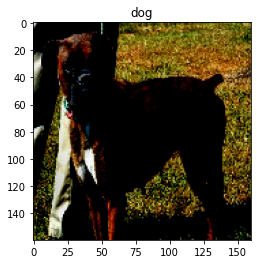

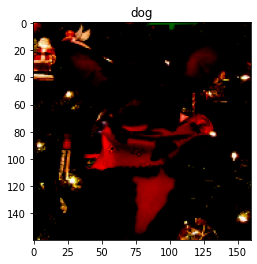

In [0]:
for image, label in train.take(2):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

In [0]:
for img, label in raw_train.take(2):
  print("original shape", img.shape)

for img, label in train.take(2):
  print("New shape:", img.shape)

original shape (262, 350, 3)
original shape (409, 336, 3)
New shape: (160, 160, 3)
New shape: (160, 160, 3)


In [0]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

# Pretrained Model

In [0]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [0]:
base_model.summary()

In [0]:
for image, _ in train_batches.take(1):
  pass
feature_batch = base_model(image)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [0]:
base_model.trainable = False

In [0]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [0]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [0]:
prediction_layer = keras.layers.Dense(1, activation='sigmoid')

In [0]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [0]:
initial_epochs = 10
validation_steps = 20

loss0, accuracy0 = model.evaluate(validation_batches, steps=validation_steps)

20/20 [==============================] - 1s 57ms/step - loss: 0.7410 - accuracy: 0.4906


In [0]:
history = model.fit(train_batches, epochs=initial_epochs,
                    validation_data=validation_batches)

acc = history.history['accuracy']
print(acc)

Epoch 1/10
582/582 [==============================] - 54s 93ms/step - loss: 0.5850 - accuracy: 0.8803 - val_loss: 0.5297 - val_accuracy: 0.9635
Epoch 2/10
582/582 [==============================] - 54s 92ms/step - loss: 0.5306 - accuracy: 0.9714 - val_loss: 0.5175 - val_accuracy: 0.9708
Epoch 3/10
582/582 [==============================] - 54s 93ms/step - loss: 0.5233 - accuracy: 0.9767 - val_loss: 0.5132 - val_accuracy: 0.9776
Epoch 4/10
582/582 [==============================] - 54s 92ms/step - loss: 0.5201 - accuracy: 0.9794 - val_loss: 0.5110 - val_accuracy: 0.9794
Epoch 5/10
582/582 [==============================] - 54s 93ms/step - loss: 0.5183 - accuracy: 0.9803 - val_loss: 0.5096 - val_accuracy: 0.9802
Epoch 6/10
582/582 [==============================] - 54s 93ms/step - loss: 0.5170 - accuracy: 0.9818 - val_loss: 0.5086 - val_accuracy: 0.9807
Epoch 7/10
582/582 [==============================] - 54s 93ms/step - loss: 0.5161 - accuracy: 0.9823 - val_loss: 0.5079 - val_accuracy:

In [0]:
preds = model.predict(test_batches)

In [0]:
test_labels = []
for image, label in raw_test:
  test_labels.append(label.numpy())
test_labels = np.array(test_labels)

In [0]:
preds[preds >= 0.5] = 1
preds[preds < 0.5] = 0

In [0]:
preds[:5]

array([[0.],
       [1.],
       [1.],
       [0.],
       [0.]], dtype=float32)

In [0]:
np.count_nonzero(np.equal(test_labels, preds.flatten())) / len(test_labels)

0.9828030954428203

In [0]:
print(preds.flatten())
print(test_labels)

[0. 1. 1. ... 0. 1. 0.]
[0 1 1 ... 0 1 0]


In [0]:
model.evaluate(test_batches)

73/73 [==============================] - 4s 58ms/step - loss: 0.5126 - accuracy: 0.9828


[0.5125632882118225, 0.9828031063079834]

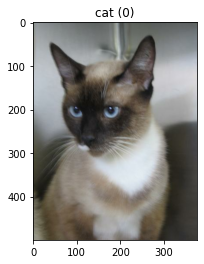

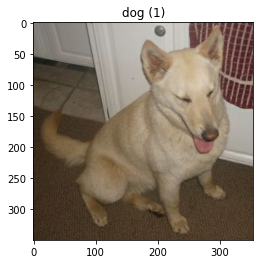

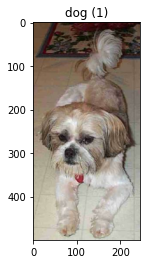

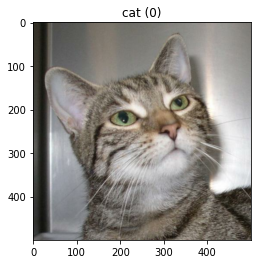

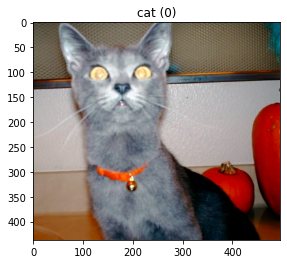

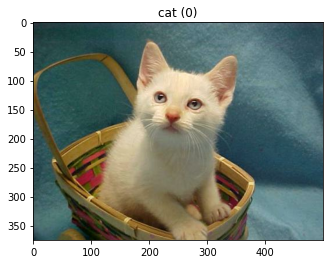

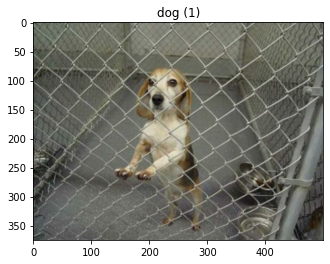

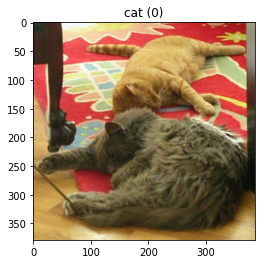

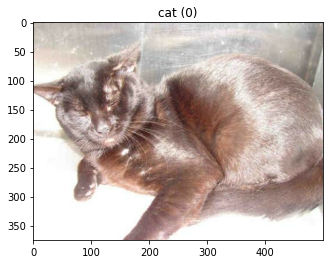

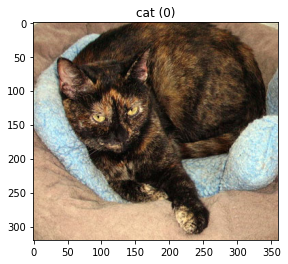

In [0]:
for image, label in raw_test.take(10):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label)+ ' (' + str(label.numpy()) + ')')